### Resource

- [google drive](https://drive.google.com/drive/u/1/folders/1N15PTA1y0ou5YyPDUN-MdlTGPXq3Rxhc)
- [iowa liquor dataset](https://console.cloud.google.com/bigquery?authuser=1&invt=AbtrQg&project=solid-dominion-452916-p4&supportedpurview=project&ws=!1m5!1m4!4m3!1sbigquery-public-data!2siowa_liquor_sales!3ssales)
- [iowa population by county](https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc/about_data)
- [iowa population by city](https://data.iowa.gov/Community-Demographics/Iowa-Population-by-City-ACS-5-Year-Estimates-/26ad-icvy/about_data)
- [iowa income](https://data.iowa.gov/Economic-Statistics/Annual-Personal-Income-for-State-of-Iowa-by-County/st2k-2ti2/about_data)
- [iowa fuel sales](https://data.iowa.gov/Sales-Distribution/Iowa-Motor-Fuel-Sales-by-County-and-Year/hbwp-wys3/about_data)
- [iowa excessive drinking](https://www.countyhealthrankings.org/health-data/community-conditions/health-infrastructure/health-promotion-and-harm-reduction/excessive-drinking?state=19&tab=1&year=2025)

### Packages

In [2]:
import pandas_gbq
from google.oauth2 import service_account
import pandas as pd
import plotnine as p9
from sodapy import Socrata

# 1. Load Data

In [3]:
SERVICE_ACCOUNT_FILE = 'secret/service_account_key.json'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

sql = """
SELECT 
    date,
    store_name,
    city,
    county,
    store_location,
    item_description,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date>='2024-01-01' AND date<'2025-01-01' AND state_bottle_cost>0 AND state_bottle_retail>0
AND bottles_sold>0 AND sale_dollars>0
"""

df_google_cloud = pandas_gbq.read_gbq(sql, credentials=credentials)

c:\repos\fred-naga-lab2\.venv\lib\site-packages\google\cloud\bigquery\table.py:2621: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.


In [4]:
df_google = df_google_cloud.copy()
df_google['gross_profit'] = (
    (df_google['state_bottle_retail'] - df_google['state_bottle_cost']) * df_google['bottles_sold']
)
df_google.rename(columns={
    'store_name': 'store',
    'item_description': 'item',
    'bottles_sold': 'bottles',
}, inplace=True)
df_google.columns = df_google.columns.str.lower()
df_google['store'] = df_google['store'].str.lower()
df_google['city'] = df_google['city'].str.lower()
df_google['county'] = df_google['county'].str.lower()
df_google['item'] = df_google['item'].str.lower()
df_google.head()

,date,store,city,county,store_location,item,state_bottle_cost,state_bottle_retail,bottles,sale_dollars,gross_profit
0,2024-11-07,super quick liquor / wdm,west des moines,polk,POINT(-93.7366 41.59907),rumchata coconut mini,8.87,13.31,1,13.31,4.44
1,2024-07-16,casey's general store # 3604/hinton,hinton,plymouth,POINT(-96.292271035 42.62768698),frost trail vodka mini,3.93,5.90,1,5.90,1.97
2,2024-10-09,hy-vee food store #1 (1013) / ames,ames,story,POINT(-93.56332 42.02297),killr variety pack mini,27.28,40.92,1,40.92,13.64
3,2024-09-06,snak atak #53 / keystone,keystone,benton,POINT(-92.19867 42.00358),crown royal vanilla mini,5.76,8.64,1,8.64,2.88
4,2024-01-24,hy-vee #5 / davenport,davenport,scott,POINT(-90.612322963 41.536627007),crown royal regal apple mini,9.95,14.93,1,14.93,4.98


In [4]:
print("The earliest date:", df_google['date'].min())
print("The latest date:", df_google['date'].max())
print("# of stores:", df_google['store'].nunique())
print("# of cities:", df_google['city'].nunique())
print("# of counties:", df_google['county'].nunique())
print("# of items:", df_google['item'].nunique())

The earliest date: 2024-01-01
The latest date: 2024-12-31
# of stores: 2150
# of cities: 471
# of counties: 99
# of items: 4515


## 1-1. Liquor Stores

In [6]:
df_store = (
    df_google
    .groupby(['store', 'city', 'county', 'date', 'item'])
    .agg({
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_store

,store,city,county,date,item,bottles,gross_profit
0,'da booze barn / west bend,west bend,palo alto,2024-01-04,99 fruits mini,1,25.8
1,'da booze barn / west bend,west bend,palo alto,2024-01-04,barton vodka,6,21.18
2,'da booze barn / west bend,west bend,palo alto,2024-01-04,cabo wabo blanco,6,63.0
3,'da booze barn / west bend,west bend,palo alto,2024-01-04,canadian ltd whisky,6,30.0
4,'da booze barn / west bend,west bend,palo alto,2024-01-04,captain morgan original spiced mini,1,2.4
...,...,...,...,...,...,...,...
2346519,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,canadian ltd whisky,24,27.12
2346520,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,crown royal,12,105.0
2346521,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey,102,298.08
2346522,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey mini dispenser,1,12.9


In [6]:
print('Summary of bottles:\n', df_store['bottles'].describe())
print()
print('Summary of gross profit:\n', df_store['gross_profit'].describe())

Summary of bottles:
 count    2346524.0
mean     13.388305
std      38.264989
min            1.0
25%            3.0
50%            6.0
75%           12.0
max        13230.0
Name: bottles, dtype: Float64

Summary of gross profit:
 count     2346524.0
mean      63.605673
std      225.560733
min            0.48
25%            18.0
50%            33.0
75%           62.16
max         87273.0
Name: gross_profit, dtype: Float64


## 1-2. Population

In [7]:
df_pop_city = pd.read_csv('https://mydata.iowa.gov/resource/26ad-icvy.csv')
df_pop_city.columns = df_pop_city.columns.str.lower()
df_pop_city.rename(columns={
    'name': 'city',
    'value': 'pop_city',
    'data_collection_period': 'year'
}, inplace=True)
df_pop_city['city'] = df_pop_city['city'].str[:-6]
df_pop_city['city'] = df_pop_city['city'].str.lower()
df_pop_city['year'] = df_pop_city['year'].str[-4:]
df_pop_city = df_pop_city[['city', 'year', 'pop_city']]
df_pop_city = df_pop_city[df_pop_city['year']=='2022']
df_pop_city['pop_city'] = df_pop_city['pop_city'].astype(int)
df_pop_city = df_pop_city[['city', 'pop_city']]
df_pop_city

,city,pop_city
0,ackley,1699
1,ackworth,106
2,adair,828
3,adel,6090
4,afton,1105
...,...,...
936,yale,316
937,yetter,16
938,yorktown,35
939,zearing,655


In [8]:
df_pop_county = pd.read_csv('data/population_county.csv')
df_pop_county.columns = df_pop_county.columns.str.lower()
df_pop_county.rename(columns={
    'population': 'pop_county'
}, inplace=True)
df_pop_county['year'] = df_pop_county['year'].str[-4:]
df_pop_county['county'] = df_pop_county['county'].str[:-7]
df_pop_county['county'] = df_pop_county['county'].str.lower()
df_pop_county = df_pop_county[['county', 'year', 'pop_county']]
df_pop_county = df_pop_county[df_pop_county['year']=='2023']
df_pop_county

,county,year,pop_county
35,poweshiek,2023,18453
134,jefferson,2023,15440
158,chickasaw,2023,11658
242,mitchell,2023,10518
245,wright,2023,12656
...,...,...,...
3191,webster,2023,36485
3255,plymouth,2023,25722
3288,fayette,2023,19210
3328,jasper,2023,37919


## 1-3. Income

In [9]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("st2k-2ti2",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_income = pd.DataFrame.from_records(df_list)

df_income['date'] = df_income['date'].str[:4]
df_income = df_income[
    (df_income['date']=='2022') & 
    (df_income['variable']=='Per capita personal income')
    ]
df_income.rename(columns={
    'name': 'county',
    'date': 'year',
    'value': 'annual_income',
}, inplace=True)
df_income['county'] = df_income['county'].str.lower()
df_income = df_income[['county', 'year', 'annual_income']]
df_income['annual_income'] = pd.to_numeric(df_income['annual_income'], errors='coerce')
df_income

,county,year,annual_income
51,adair,2022,67668
103,adams,2022,67657
155,allamakee,2022,55015
207,appanoose,2022,47779
259,audubon,2022,69105
...,...,...,...
4939,winnebago,2022,55013
4991,winneshiek,2022,61042
5043,woodbury,2022,51029
5095,worth,2022,55418


## 1-4. Fuel Sales

In [10]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("hbwp-wys3",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_fuel = pd.DataFrame.from_records(df_list)
df_fuel.rename(columns={
    'calendar_year': 'year',
    # 'number_of_retail_locations': 'locations',
    'non_ethanol_gas_sales': 'gas_sales',
}, inplace=True)
df_fuel = df_fuel[df_fuel['year']=='2024']
df_fuel['county'] = df_fuel['county'].str.lower()
df_fuel = df_fuel[['county', 'gas_sales']]
df_fuel

,county,gas_sales
1174,adair,895851
1175,adams,188155
1176,allamakee,923224
1177,appanoose,792131
1178,audubon,226034
...,...,...
1268,winnebago,582020
1269,winneshiek,976372
1270,woodbury,7032420
1271,worth,445045


## 1-5. Excessive Drinking

In [11]:
df_drinking = pd.read_csv('data/excessive_drinking.csv')
df_drinking.columns = df_drinking.columns.str.lower()
df_drinking.rename(columns={
    'county value**': 'excessive_drinking_percent',
}, inplace=True)
df_drinking['county'] = df_drinking['county'].str.lower()
df_drinking['excessive_drinking_percent'] = df_drinking['excessive_drinking_percent'].str[:2]
df_drinking = df_drinking[['county', 'excessive_drinking_percent']]
df_drinking

,county,excessive_drinking_percent
0,iowa,25
1,adair,24
2,adams,25
3,allamakee,23
4,appanoose,23
...,...,...
95,winnebago,24
96,winneshiek,27
97,woodbury,25
98,worth,25


# 2. Exploere Data

## 2-1. Data Frame

In [12]:
df_county = pd.merge(df_pop_county, df_income, on='county', how='left')
df_county = pd.merge(df_county, df_fuel, on='county', how='left')
df_county = pd.merge(df_county, df_drinking, on='county', how='left')
df_county = df_county[['county', 'pop_county', 'annual_income', 'gas_sales', 'excessive_drinking_percent']]
df = pd.merge(df_store, df_pop_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df

,store,city,county,date,item,bottles,gross_profit,pop_city,pop_county,annual_income,gas_sales,excessive_drinking_percent
0,'da booze barn / west bend,west bend,palo alto,2024-01-04,99 fruits mini,1,25.8,936.0,8810,65080,306384,26
1,'da booze barn / west bend,west bend,palo alto,2024-01-04,barton vodka,6,21.18,936.0,8810,65080,306384,26
2,'da booze barn / west bend,west bend,palo alto,2024-01-04,cabo wabo blanco,6,63.0,936.0,8810,65080,306384,26
3,'da booze barn / west bend,west bend,palo alto,2024-01-04,canadian ltd whisky,6,30.0,936.0,8810,65080,306384,26
4,'da booze barn / west bend,west bend,palo alto,2024-01-04,captain morgan original spiced mini,1,2.4,936.0,8810,65080,306384,26
...,...,...,...,...,...,...,...,...,...,...,...,...
2358726,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,canadian ltd whisky,24,27.12,690.0,14396,66517,529531,24
2358727,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,crown royal,12,105.0,690.0,14396,66517,529531,24
2358728,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey,102,298.08,690.0,14396,66517,529531,24
2358729,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey mini dispenser,1,12.9,690.0,14396,66517,529531,24


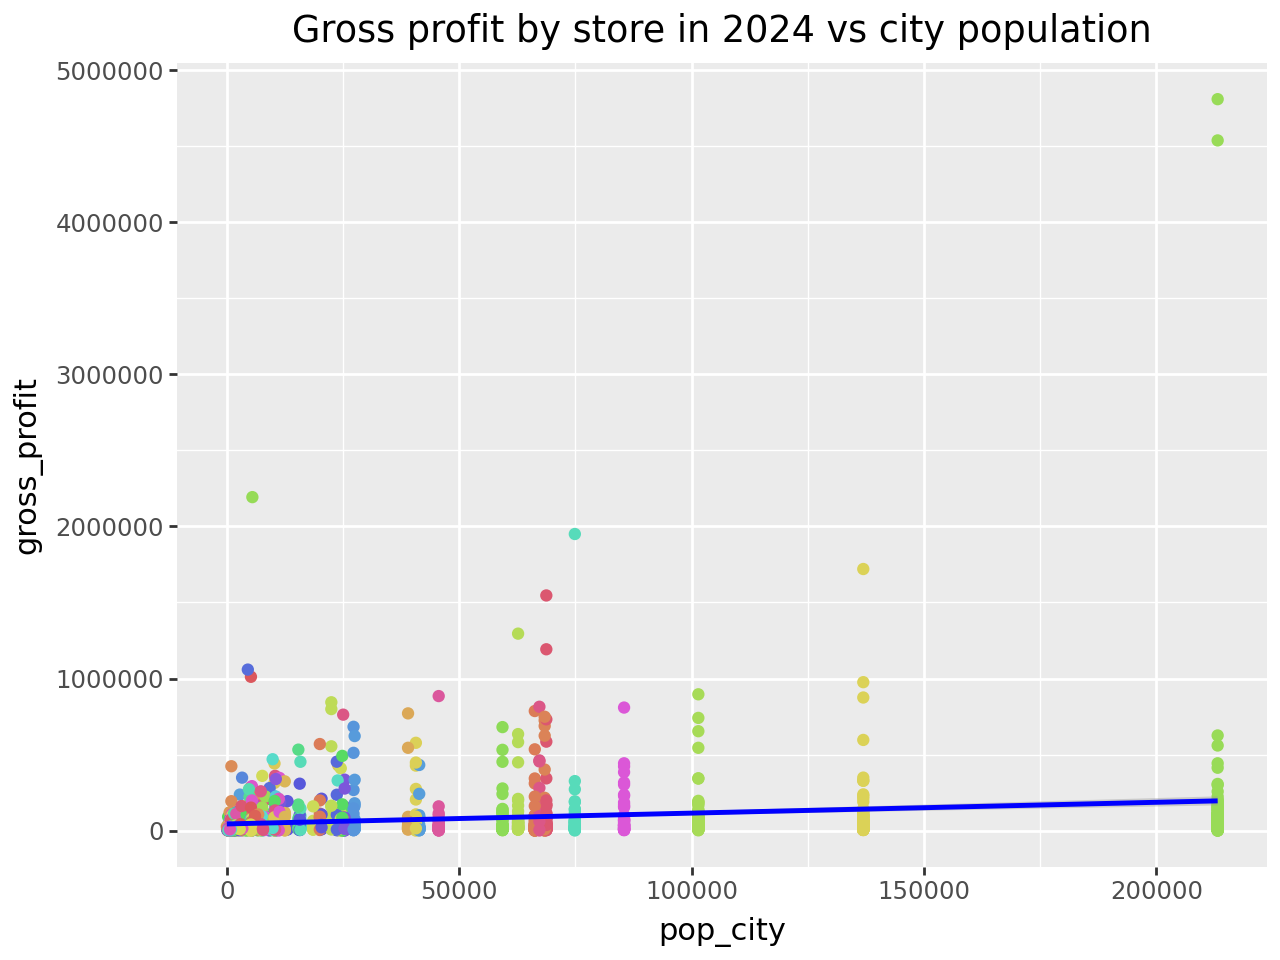

In [19]:
df_store_pop = df.groupby(['store', 'pop_city', 'city'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_pop, p9.aes(x='pop_city', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs city population') +
    p9.theme(legend_position='none')
)
plot

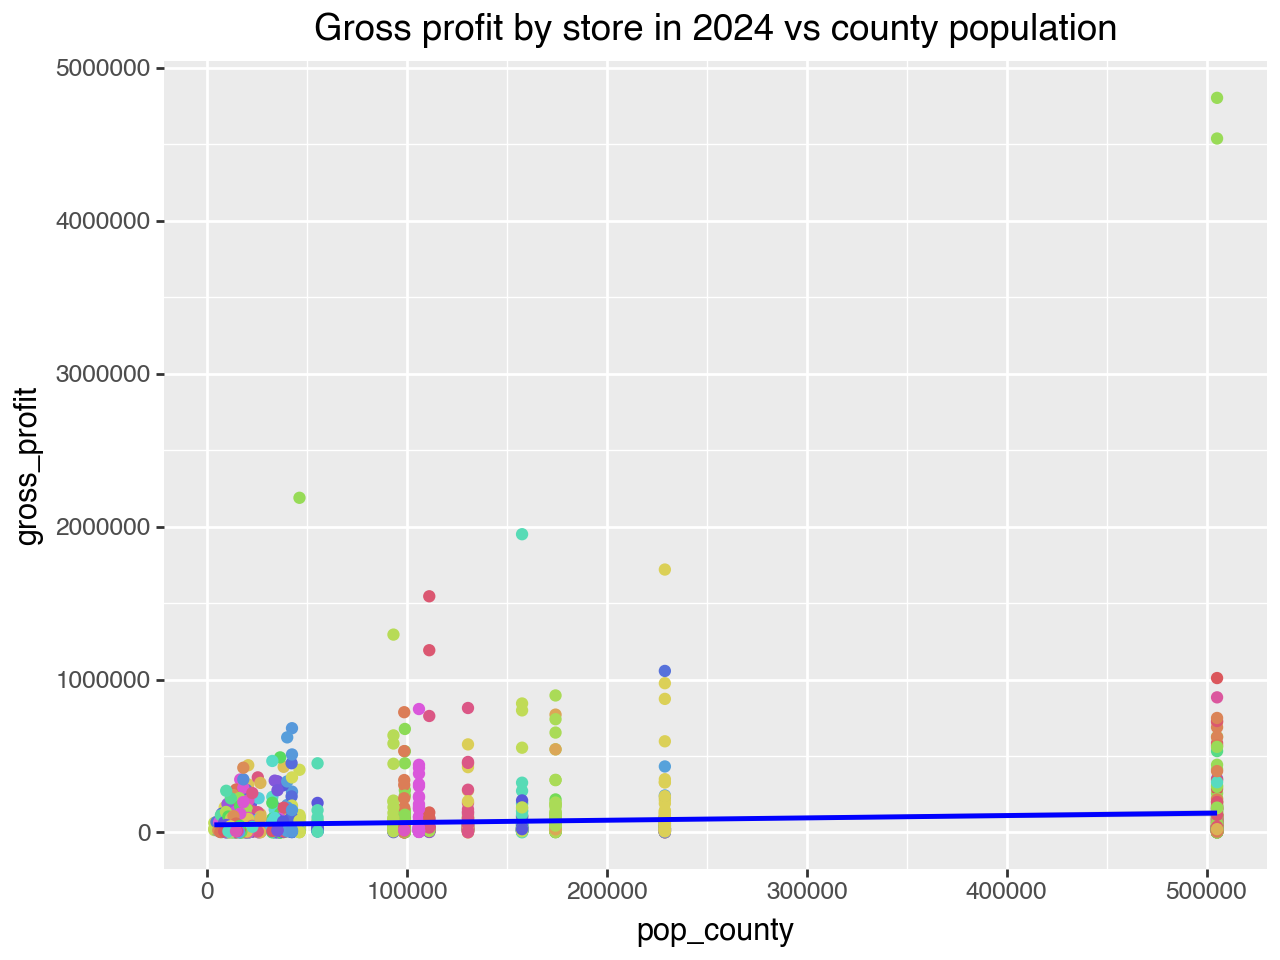

In [134]:
df_store_pop_county = df.groupby(['store', 'pop_county', 'city'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_pop_county, p9.aes(x='pop_county', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs county population') +
    p9.theme(legend_position='none')
)
plot

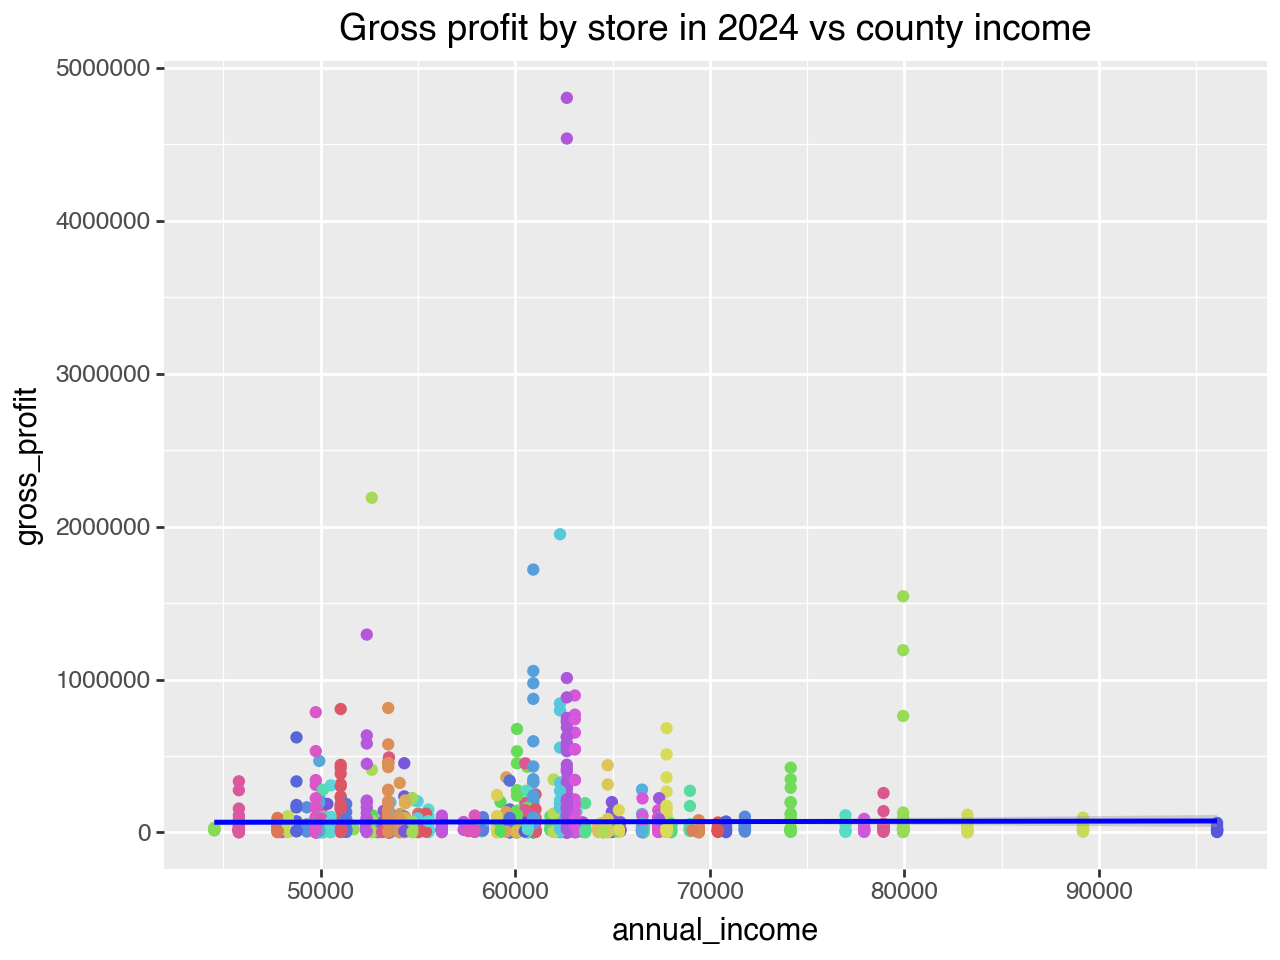

In [136]:
df_store_income = df.groupby(['store', 'annual_income', 'county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_income, p9.aes(x='annual_income', y='gross_profit', color='county')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs county income') +
    p9.theme(legend_position='none')
)
plot

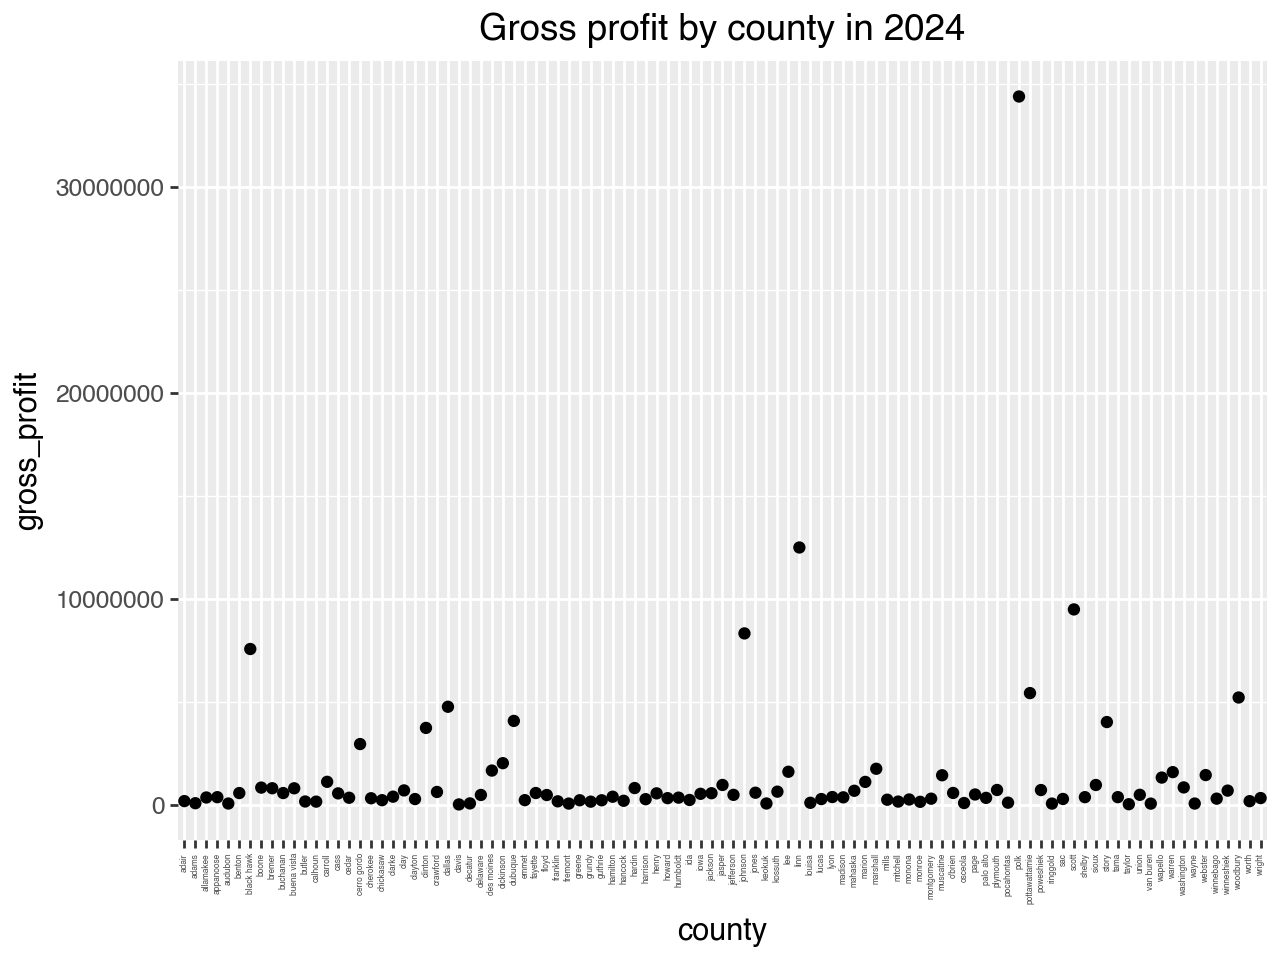

In [127]:
df_county_profit = df.groupby(['county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_county_profit, p9.aes(x='county', y='gross_profit')) +
    p9.geom_point() +
    p9.labs(title='Gross profit by county in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot

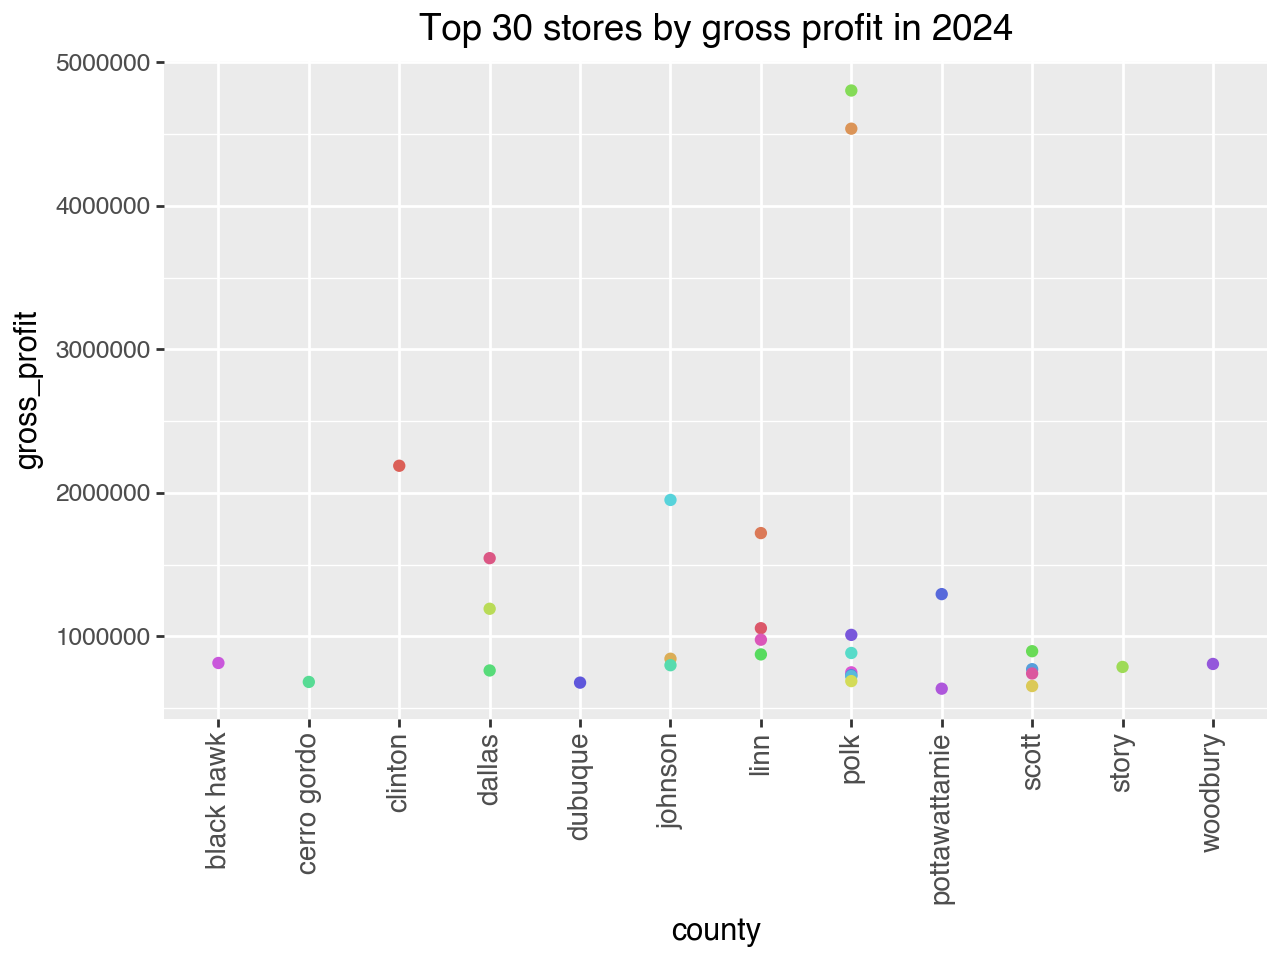

In [150]:
df_top_store = df.groupby(['store', 'city', 'county'])['gross_profit'].sum().reset_index(name='gross_profit')
df_top_store = df_top_store.nlargest(30, 'gross_profit')
plot = (
    p9.ggplot(df_top_store, p9.aes(x='county', y='gross_profit', color='store')) +
    p9.geom_point() +
    p9.labs(title='Top 30 stores by gross profit in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=10),
             legend_position='none')
)
plot

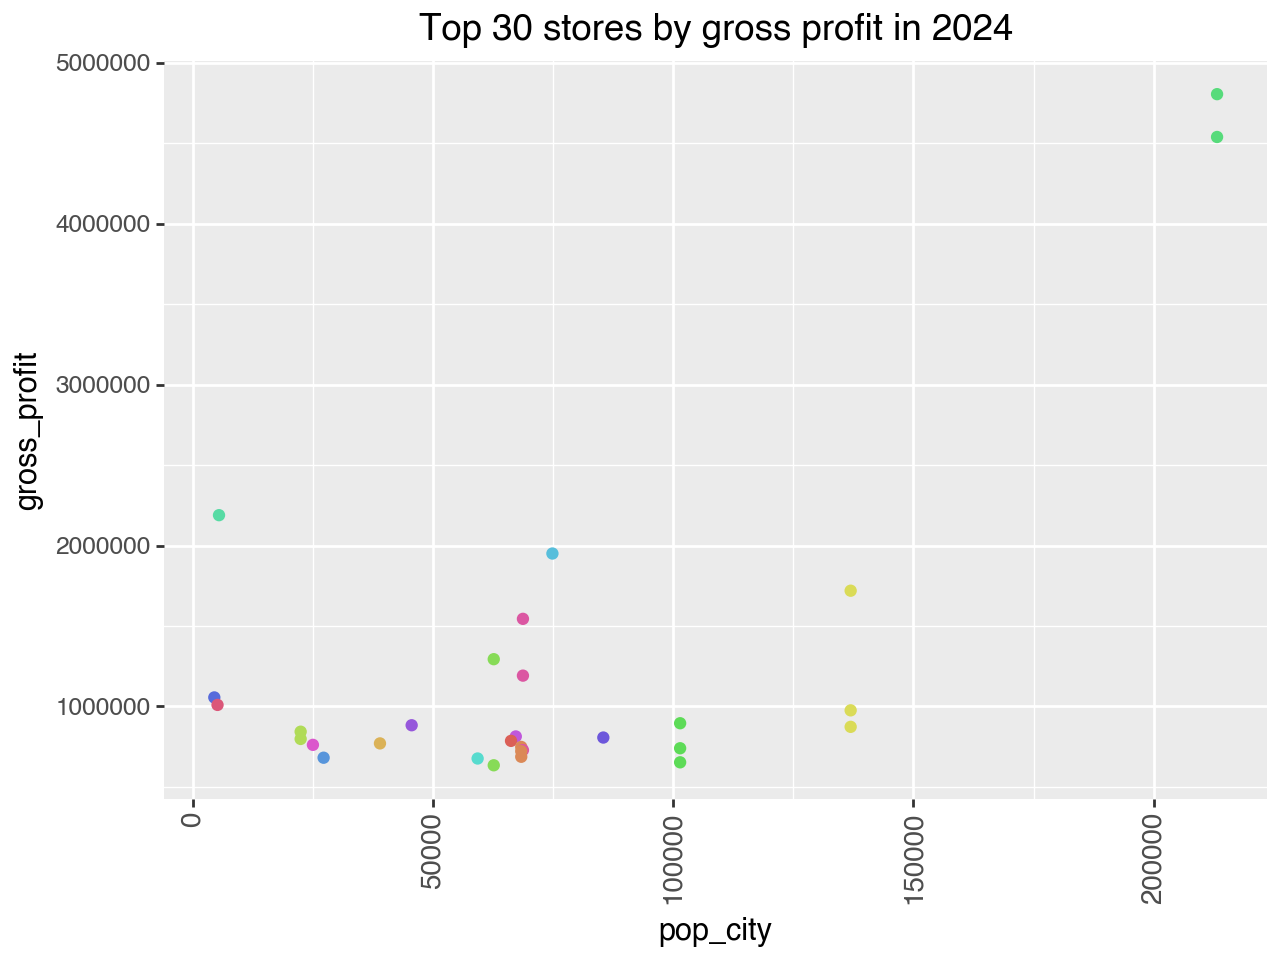

In [155]:
df_top_store = df.groupby(['store', 'city', 'county', 'pop_city'])['gross_profit'].sum().reset_index(name='gross_profit')
df_top_store = df_top_store.nlargest(30, 'gross_profit')
plot = (
    p9.ggplot(df_top_store, p9.aes(x='pop_city', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.labs(title='Top 30 stores by gross profit in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=10),
             legend_position='none')
)
plot

In [23]:
unique_names = df_store['store'].unique()
print(unique_names)
print(len(unique_names))

["'da booze barn / west bend" '10th hole inn & suite / gift shop'
 '173 craft distillery (et)' ... 'yesway store # 1029/ clarion'
 'yesway store # 1036/ kanawha' 'yesway store #1198 / swea city']
2150


## Categories Explanation

The following code block creates categories for the dataframe. They are as follows:

1. Grocery Store - Primarily sells food or groceries
2. Liquor Store/Bar - Stores that mainly sell liquor, including some bars/grills
3. Gas Station - Any store that sells gas with their products
4. Pharmacy - Stores that principally sell medicine
5. Distillery/Brewery - Locations that make their own liquor/wine/beer. This could be merged with Liquor Store/Bar
6. General Store - Sells a small selection of food in addition to hardware or a wider range of products
7. Convenience Store - Sells a smaller selection of food, typically open 24/7
8. Other - Includes strip clubs, amusement parks, gift shops, department stores, malls, auto service or other difficult to categorize stores
9. Unknown - Stores without enough publicly available information to classify them into one of the earlier categories

In [ ]:
import re

def assign_category(store_name):
    # Ensure store_name is a string; if not, use an empty string.
    store = store_name.lower() if isinstance(store_name, str) else ""
    
    # Remove punctuation from the store name to avoid matching issues with characters like '/'
    store_clean = store
    
    # General stores and convenience stores may be combined later
    # Brew oil is a chain of liquor stores at gas stations. Included under gas station for now
    # The difference between convenience store and gas station, is the latter also sells gas
    # Some meat only stores are placed into grocery stores (fire and salt co, forbes meat)
    categories = {
        "grocery store": ["groc", "super saver iv", "sunshine foods", "sioux food center", "shivam food mart llc", "save more", "food pride", "sam's food", "sam food mart", "roy's foodland", "quillins quality foods", "quillins food ranch", "osco #1118", "state food mart", "strawberry food", "stratford food center", "super saver iv," "sam food mart", "ruback's food center", "terry's food center", "sam's club", "target", "price chopper", "quillins quality foods west union", "r&l foods", "mepo foods", "montezuma super valu", "mcnally's super valu", "maynards", "mapleton food land", "logan super foods", "laurens food pride", "lake city food center", "lansing iga", "lake view foods",  "la tropicana", "kyaw family, inc", "jim and charlies affiliated", "keota eagle foods", "jubilee foods", "jeff's foods", "jeffs foods", "jack & jill store", "ida grove food pride", "gary's foods", "grandview mart", "hy-vee", "hometown foods", "the food center", "frohlich's super valu", "fredricksburg food center", "freeman foods", "fire and salt co", "forbes meat", "feista foods", "family fare",  "fairbank food center", "el valle tienda y carniceria", "davids foods", "thriftway", "country foods", "tipton family foods", "center point foods", "dashmart", "corwith farm service", "clear lake payless foods", "britt food center", "fareway stores", "dutchmart", "eagle food mart", "bob & scott's", "cash saver", "best food mart", "byron mart", "big g food store", "bender's foods", "bender foods", "trunck's country foods, inc", "avoca food land", "avenue g store", "audubon food land", "costco", "whole foods", "trader joe", "wmart", "fresh", "wilkes", "wikes", "market", "wal-mart"],
        "liquor store/bar": ["8 seconds", "central city 2", "riverside #4 / bettendorf", "sun mart", "subedi llc", "ss khanna group inc", "south side food mart", "smokin hot", "sip & burn", "sid's beverage shop", "royal mart", "puff pour play inc", "jumbo's", "super quick", "the hut", "prime mart", "swarm sports bar and grille", "oasis", "the cooler", "the beverage shop", "new star", "new hampton mart", "metro mart", "malik's",  "local craft cellar", "last call 2", "kimberly mart", "hurribak iv distribution", "great pastimes", "grieder beverage depot", "the secret cellar", "essentials plus", "essentials",  "eldridge mart", "easygo", "downtown pantry", "division mart", "ding's honk'n holler", "concordia llc", "chuck's sportsmans beverage", "bani's", "cork 'n bottle", "cork and bottle", "cork it!", "brady mart", "benz distributing", "brewski", "blind pig cocktail bodega", "bootleg", "brew ida grove", "camanche food pride", "beer", "another round", "ambysure inc", "whiskey", "shack", "liquor", "booze", "spirits", "wine", "smoke", "tobacco", "ali's"],
        "gas station": ["yana mart", "super convenience store", "speede shop", "southgate ames", "snak atak #53", "site food mart", "sioux-per center", "sinclair", "select mart", "rolfe heartland", "river mart", "rina mart llc", "quik and handi", "quick shop foods", "quick mart", "quick corner", "pump n pack", "primestar", "porters convenience 66", "pony express", "oak street station llc", "speedee mart", "stan's corner", "star / denison", "star convenience", "super mart", "quik n handi iii", "truck plaza inc.", "shop n save", "pump 'n pak", "raymond's station", "taylor's", "phillips 66", "the spot #3", "otho convenience and food", "oskaloosa watering hole", "oly's c store", "oelwein mart", "panther travel center", "quik pik", "raceway 80", "quik trip", "the pumper", "the corner store", "the boonedocks", "naaz group llc", "moes mart", "mod /", "mk minimart, inc", "mini-mart", "mega saver", "mega retail", "mcdermott oil", "mason mart", "martelle store", "locust mart", "lefty's convenience", "l&m mighty shop", "kramer's inc.", "jiffy", "the depot", "kwik star", "kwik shop", "konvenience korner", "kline's quick time", "kimmes", "kj's convenience & deli", "karam kaur khasriya llc", "jj's valley mart", "country store", "indy 66", "gd xpress", "garner foods", "fastland llc", "crossroads / hampton", "the depot williamsburg", "hill country convenience store", "hill brothers jiffy mart", "hello mart llc", "golden mart", "good and quick co", "hawkeye convenience store", "filling station", "the station", "speed shoppe", "speede shoppe", "fast break", "ampride", "fas mart", "engen express", "ehlinger's vinton express", "dhakals llc", "dewitt travel mart", "depot norway", "decorah mart", "day break", "cresco mart", "corydon corner", "circle s", "budzz", "ez mart", "e z mart", "express mart", "cubby's", "corner mart", "bucky's", "central mart i, llc", "conoco", "car-go-express", "circle k", "best trip", "thunder ridge", "the station ii", "calamus country store", "brew floyd", "tiger mart", "casey's", "brew oil", "shell", "bailey's convenience", "b and b west", "b p on 1st", "uni mart", "andrew country mart", "westland fast", "westside houser mart", "junction", "gas", "sheetz", "four corners", "petro", "wawa", "bp", "quiktrip", "buc-ee", "380bp", "fuel", "kum", "stop", "yesway", "wilton express", "williams travel"],
        "pharmacy": ["pharmacy", "cvs", "walgreen", "cornerstone apothecary", "hartig drug"],
        "distillery/brewery": ["distill", "legendary rye", "brewery", "vineyard", "catfish charlie's"],
        "general store": ["general", "bellevue express", "guppy's on the go", "huber's store", "gateway mart" ],
        "convenience store": ["7/11", "sahota food mart", "station mart", "sycamore convenience", "mughal, inc", "neighborhood mart", "moti's food", "mad ave quik shop", "kc brothers", "jim's food", "east village pantry", "family pantry", "gm minimart", "gm mart", "gm food mart",  "bravim mart incorporated", "carson country store llc", "big 10 mart", "umiya foodmart inc", "7 days mart", "valley west corner store", "mini mart", "west k mart"],
        "other": ["williams boulevard service", "sodes green acre", "prairie meadows", "gopuff", "ib pony", "new york dollar store", "franklin street floral & gift", "eichman enterprises inc", "inn & suites", "budget inn", "10th", "adventureland", "whiting", "casino", "w&h cooperative oil co", "troy mills / troy mills" ],
        "unknown" : ["best deals / waterloo", "k-zar inc - waterloo", "kc store / stratford", "larchwood offsale", "rienbeck gp llc / reinbeck"] 
    }
    
    # Loop over the categories in the order given.
    for category, keywords in categories.items():
        # If any keyword is found in the cleaned store name, return the category.
        if any(keyword in store_clean for keyword in keywords):
            return category
    return "uncategorized"

# Example: Apply the improved function to assign a category in your DataFrame.
df['category'] = df['store'].apply(assign_category)
print(df[['store', 'category']])

                                  store          category
0            'da booze barn / west bend  liquor store/bar
1            'da booze barn / west bend  liquor store/bar
2            'da booze barn / west bend  liquor store/bar
3            'da booze barn / west bend  liquor store/bar
4            'da booze barn / west bend  liquor store/bar
...                                 ...               ...
2358726  yesway store #1198 / swea city       gas station
2358727  yesway store #1198 / swea city       gas station
2358728  yesway store #1198 / swea city       gas station
2358729  yesway store #1198 / swea city       gas station
2358730  yesway store #1198 / swea city       gas station

[2358731 rows x 2 columns]


In [74]:
# Filter rows with category equal to "uncategorized"
uncategorized_stores = df[df['category'] == "uncategorized"]
print(uncategorized_stores[['store', 'category']])


                             store       category
1879454  riverside #4 / bettendorf  uncategorized
1879455  riverside #4 / bettendorf  uncategorized
1879456  riverside #4 / bettendorf  uncategorized
1879457  riverside #4 / bettendorf  uncategorized
1879458  riverside #4 / bettendorf  uncategorized
...                            ...            ...
1880852  riverside #4 / bettendorf  uncategorized
1880853  riverside #4 / bettendorf  uncategorized
1880854  riverside #4 / bettendorf  uncategorized
1880855  riverside #4 / bettendorf  uncategorized
1880856  riverside #4 / bettendorf  uncategorized

[1403 rows x 2 columns]


In [75]:
# Assuming other_stores is the DataFrame filtered for rows with category "other"
unique_uncategorized_names = uncategorized_stores['store'].unique()
print(unique_uncategorized_names)
print(len(unique_uncategorized_names))


['riverside #4 / bettendorf']
1
